# Определение уровня шума аэродинамического профиля

## Техническое задание:

Разработать модель предсказания уровня шума [Дб] по заданным характеристикам профиля и потока

# Импорт библиотек

Стандартные библиотеки

In [1]:
import os
import sys
import pickle
from tqdm import tqdm
from colorama import Fore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score,mean_squared_error

import tensorflow as tf
import torch

In [2]:
for lib in (pd, np, tf, torch):
    print(f'{lib.__name__}: {lib.__version__}')

pandas: 2.2.2
numpy: 1.26.4
tensorflow: 2.16.1
torch: 2.3.0+cpu


Частные библиотеки

In [3]:
sys.path.append('D:/Programming/Python/scripts')

In [4]:
from pandas_tools import DataFrame
#from ml_tools import SCALERS, DataFrame, Model, Stacking, Bagging, Boosting
from tensorflow_tools import training_plot, predictions_plot

# Определение констант

# Data Engeneering

## Импорт и визуализация исходных данных

In [5]:
for root, dirs, files in os.walk('datas'):
    if files:
        print('root: ', Fore.RED + root + Fore.RESET)
        print('directories: ', Fore.YELLOW + ', '.join(dirs) + Fore.RESET)
        print('files: ' + Fore.GREEN + ', '.join(files) + Fore.RESET)
        print()

root:  datas\external
directories:  
files: airfoil_self_noise.dat



In [6]:
df = pd.read_csv("datas/external/airfoil_self_noise.dat", sep="\t", header=None)
df = DataFrame(df)

In [7]:
df

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Предварительная обработка

In [8]:
df.columns = ["Frequency [Hz]", "Attack angle [deg]", "Chord length [m]", "Free-stream velocity [m/s]", "Thickness [m]", "Pressure level [db]"]

In [9]:
df.columns

Index(['Frequency [Hz]', 'Attack angle [deg]', 'Chord length [m]',
       'Free-stream velocity [m/s]', 'Thickness [m]', 'Pressure level [db]'],
      dtype='object')

Исходные данные:

1. Частота [Гц].
2. Угол атаки [град].
3. Длина хорды аэродинамического профиля [м].
4. Скорость набегающего потока [м/с].
5. Толщина аэродинамического профиля [м].

Результирующие данные:

6. Масштабированный уровень звукового давления [Дб].

In [10]:
target = 'Pressure level [db]'
df.target = target

## Обработка типов данных

In [11]:
df.info(memory_usage='deep')

<class 'pandas_tools.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Frequency [Hz]              1503 non-null   int64  
 1   Attack angle [deg]          1503 non-null   float64
 2   Chord length [m]            1503 non-null   float64
 3   Free-stream velocity [m/s]  1503 non-null   float64
 4   Thickness [m]               1503 non-null   float64
 5   Pressure level [db]         1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [12]:
categorials = df.select_dtypes(['object']).columns.to_list()
print(f'Категориальные признаки: {categorials}')

Категориальные признаки: []


In [13]:
numeric = df.select_dtypes(['int', 'float']).columns.to_list()
print(f'Числовые признаки: {numeric}')

Числовые признаки: ['Frequency [Hz]', 'Attack angle [deg]', 'Chord length [m]', 'Free-stream velocity [m/s]', 'Thickness [m]', 'Pressure level [db]']


## Обработка локальных пустот и дубликатов

In [14]:
df.isna().sum()

Frequency [Hz]                0
Attack angle [deg]            0
Chord length [m]              0
Free-stream velocity [m/s]    0
Thickness [m]                 0
Pressure level [db]           0
dtype: int64

In [15]:
df[df.duplicated()].shape

(0, 6)

## Выделение признаков

In [16]:
df['Chord length [mm]'] = df['Chord length [m]'] * 1000
df['Thickness [mm]'] = df['Thickness [m]'] * 1000

In [17]:
df.drop(['Chord length [m]', 'Thickness [m]'], axis=1, inplace=True)

In [18]:
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


## Обработка выбросов

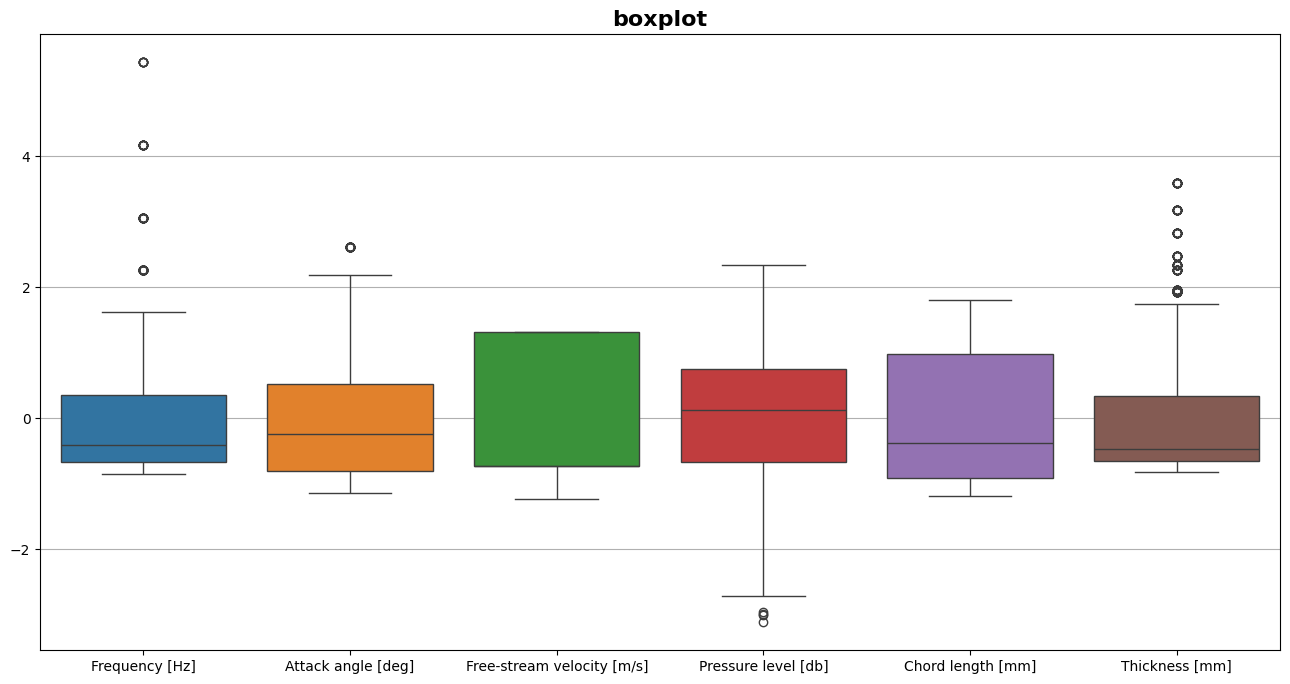

In [20]:
df.boxplot(scale=True, figsize=(16, 8))

In [21]:
df.detect_outliers('sigma')

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
12,12500,0.0,71.3,112.241,304.8,2.66337
13,16000,0.0,71.3,108.721,304.8,2.66337
28,12500,0.0,55.5,111.076,304.8,2.83081
47,12500,0.0,39.6,109.619,304.8,3.10138
78,12500,1.5,71.3,109.222,304.8,3.36729
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


In [22]:
#df = df.drop(detect_outliers(df, 'sigma').index)

In [23]:
df.detect_outliers('Tukey')

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
11,10000,0.0,71.3,115.391,304.8,2.66337
12,12500,0.0,71.3,112.241,304.8,2.66337
13,16000,0.0,71.3,108.721,304.8,2.66337
27,10000,0.0,55.5,113.076,304.8,2.83081
28,12500,0.0,55.5,111.076,304.8,2.83081
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


In [24]:
#df = df.drop(detect_outliers(df, 'Tukey').index)

In [25]:
#df.detect_model_outliers(0.05, target=target)

## Анализ сбалансированности

In [26]:
df.balance(target, threshold=2)

,count,fraction,balance
Pressure level [db],,,
127.315,3,0.001996,False
126.540,3,0.001996,False
129.395,3,0.001996,False
120.324,2,0.001331,False
110.905,2,0.001331,False
...,...,...,...
122.288,1,0.000665,False
122.235,1,0.000665,False
122.232,1,0.000665,False


In [27]:
df.balance(target, threshold=2)

,count,fraction,balance
Pressure level [db],,,
127.315,3,0.001996,False
126.540,3,0.001996,False
129.395,3,0.001996,False
120.324,2,0.001331,False
110.905,2,0.001331,False
...,...,...,...
122.288,1,0.000665,False
122.235,1,0.000665,False
122.232,1,0.000665,False


## Статистика и визуализация данных

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Frequency [Hz],1503.0,2886.380572,3152.573137,200.000000,800.00000,1600.00000,4000.0000,20000.0000
Attack angle [deg],1503.0,6.782302,5.918128,0.000000,2.00000,5.40000,9.9000,22.2000
Free-stream velocity [m/s],1503.0,50.860745,15.572784,31.700000,39.60000,39.60000,71.3000,71.3000
Pressure level [db],1503.0,124.835943,6.898657,103.380000,120.19100,125.72100,129.9955,140.9870
Chord length [mm],1503.0,136.548237,93.540728,25.400000,50.80000,101.60000,228.6000,304.8000
Thickness [mm],1503.0,11.139880,13.150234,0.400682,2.53511,4.95741,15.5759,58.4113


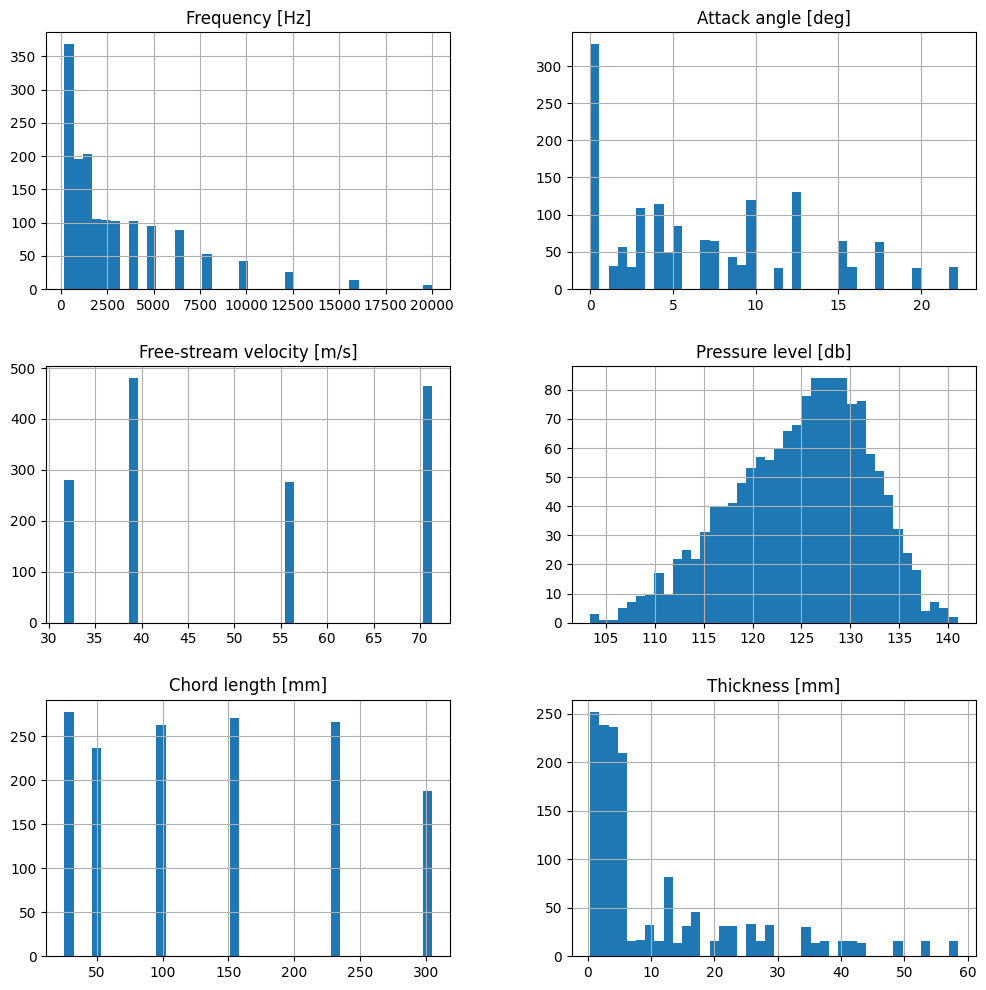

In [29]:
df.histplot()

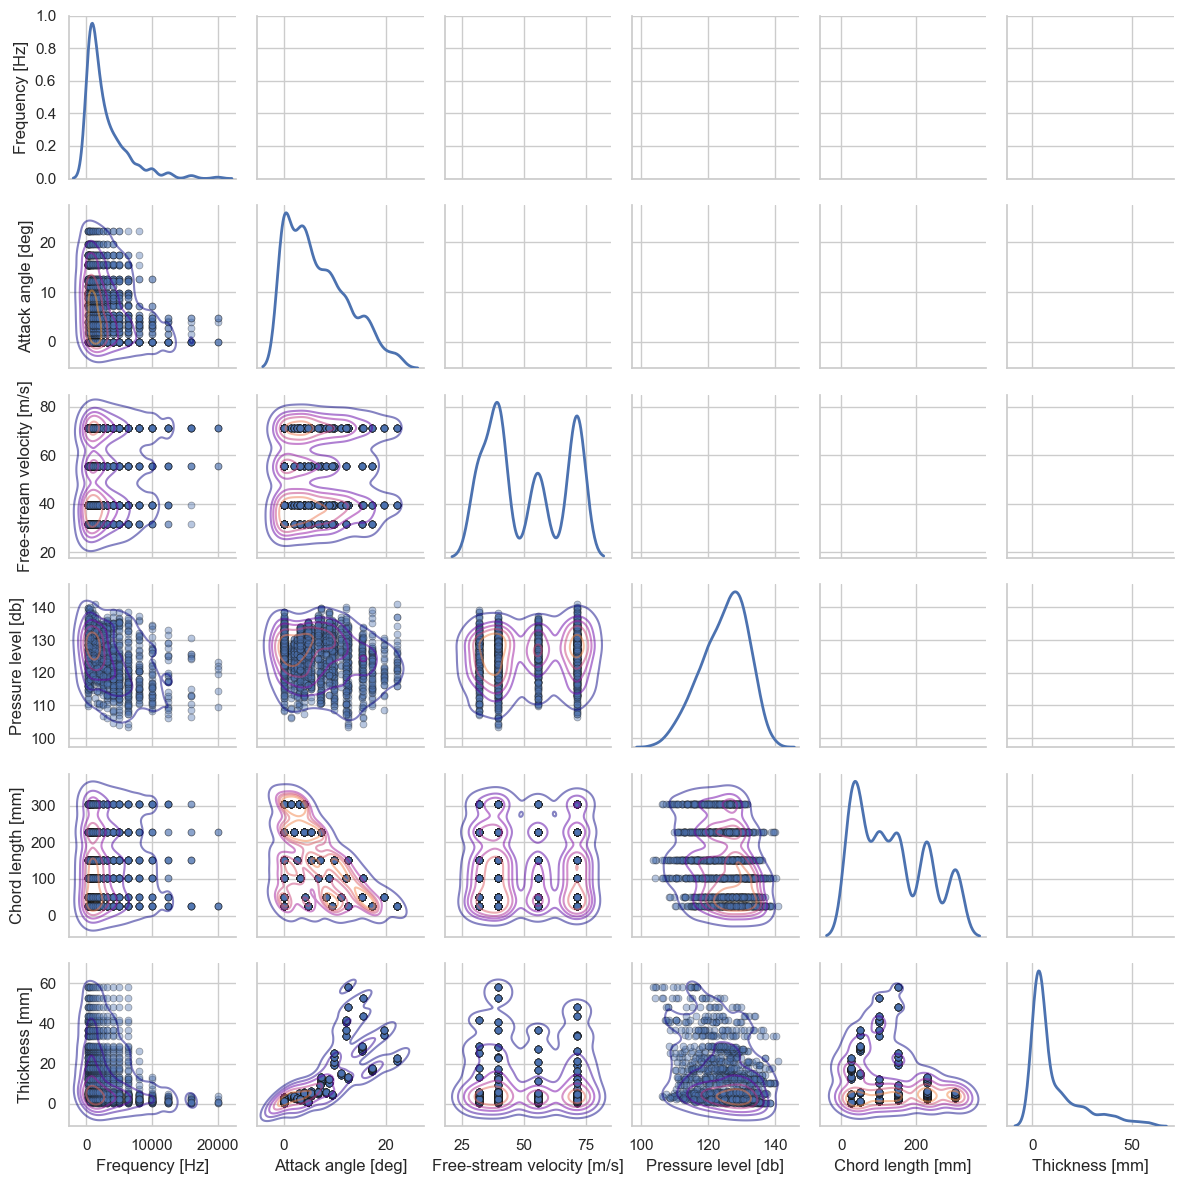

In [30]:
df.pairplot()

## Отбор признаков

### Линейно-независимые признаки

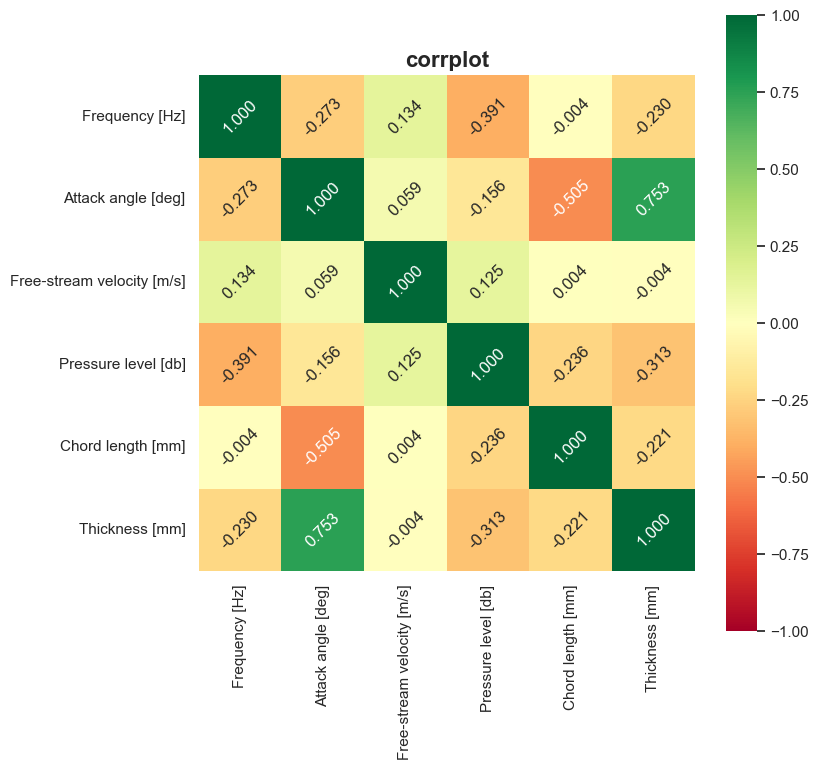

In [31]:
df.corrplot(figsize=(8, 8), fmt=3)

In [32]:
corr_features = df.corr_features(threshold=0.75)
print('Линейно-зависимые признаки:')
corr_features

Линейно-зависимые признаки:


{('Thickness [mm]', 'Attack angle [deg]'): 0.7533937846545844}

### Признаки с весомыми коэффициентами L1-регуляризации

Диапазон коэффициента L1-регуляризации

In [33]:
l1 = 2 ** np.linspace(-10, 2, 100)

In [34]:
df.l1_importance(l1=l1, scale=True, early_stopping=True, target=target)

Fitting L1-models:  95%|█████████▌| 95/100 [00:00<00:00, 1532.10it/s]


,L1,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Chord length [mm],Thickness [mm]
0,0.000977,-4.038949,-2.492872,1.553049,-3.334658,-1.936845
1,0.001062,-4.038779,-2.492595,1.552923,-3.334439,-1.936881
2,0.001155,-4.038593,-2.492293,1.552787,-3.334202,-1.936921
3,0.001257,-4.038392,-2.491966,1.552638,-3.333943,-1.936963
4,0.001367,-4.038172,-2.491609,1.552476,-3.333662,-1.937010
...,...,...,...,...,...,...
95,2.858288,-0.000000,-0.000000,0.000000,-0.000000,-0.000000
96,3.108813,NaN,NaN,NaN,NaN,NaN
97,3.381295,NaN,NaN,NaN,NaN,NaN
98,3.677659,NaN,NaN,NaN,NaN,NaN


Fitting L1-models:  95%|█████████▌| 95/100 [00:00<00:00, 1727.15it/s]


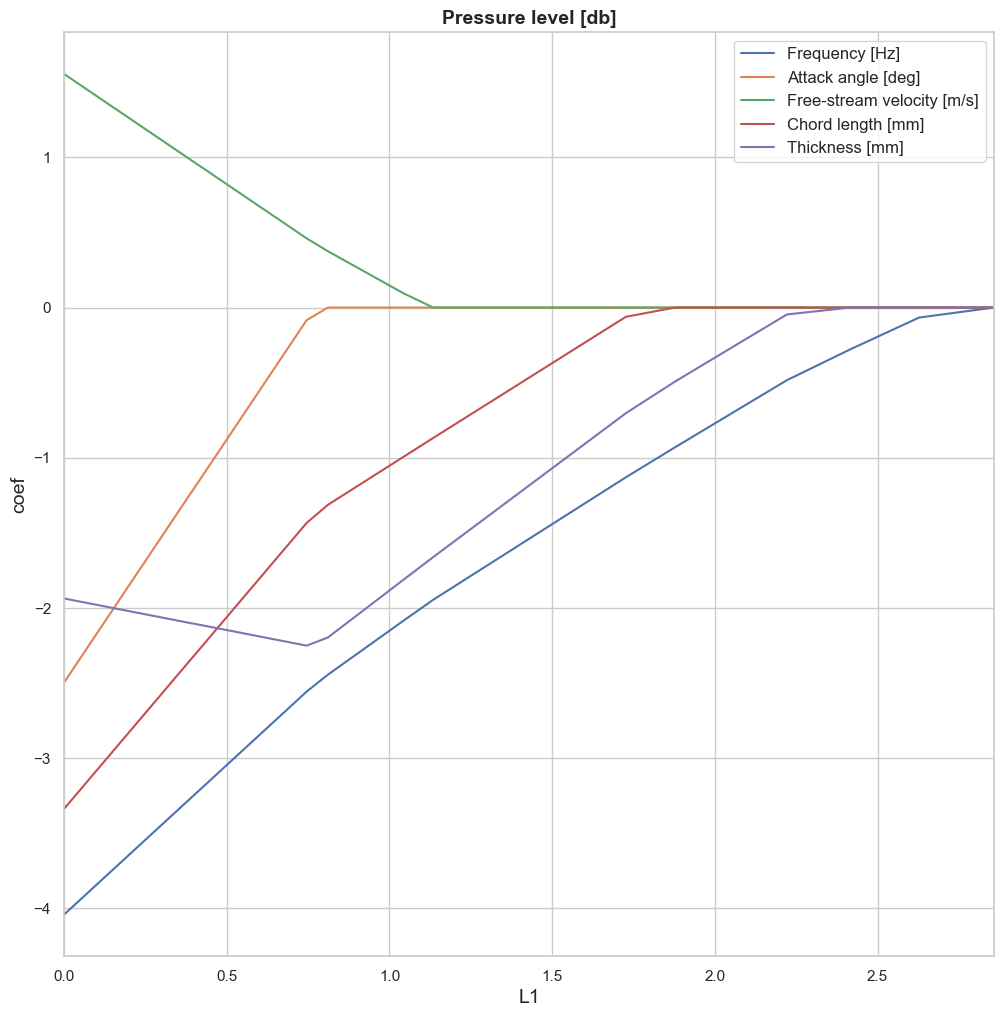

In [35]:
df.l1_importance_plot(l1=l1, scale=True, early_stopping=True, figsize=(12, 12), target=target)

In [36]:
l1_features = df.select_l1_features(len(df.columns)-1, l1=l1, scale=True, early_stopping=True, target=target)
print('Признаки с весомыми коэффициентами L1-регуляризации:')
l1_features

Fitting L1-models:  95%|█████████▌| 95/100 [00:00<00:00, 1557.26it/s]

Признаки с весомыми коэффициентами L1-регуляризации:


['Frequency [Hz]',
 'Attack angle [deg]',
 'Free-stream velocity [m/s]',
 'Chord length [mm]',
 'Thickness [mm]']

In [37]:
#df = df[l1_features]
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


### Признаки без взаимной информации корреляции

In [38]:
mutual_info_score = df.mutual_info_score(target=target)
mutual_info_score

Thickness [mm]                4.602460
Attack angle [deg]            2.980877
Frequency [Hz]                2.876181
Chord length [mm]             1.754163
Free-stream velocity [m/s]    1.327654
dtype: float64

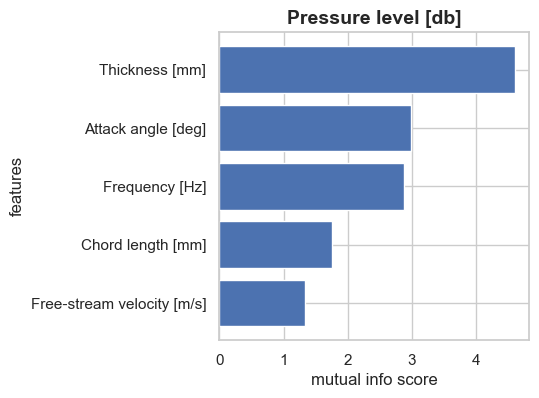

In [39]:
df.mutual_info_score_plot(figsize=(4, 4), target=target)

In [40]:
mutual_info_score_features = df.select_mutual_info_score_features(len(df.columns)-1, target=target)
print('Признаки без взаимной информации кореляции:')
mutual_info_score_features

Признаки без взаимной информации кореляции:


['Thickness [mm]',
 'Attack angle [deg]',
 'Frequency [Hz]',
 'Chord length [mm]',
 'Free-stream velocity [m/s]']

In [41]:
#df = df[mutual_info_score_features]
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


### Признаки, выбранные перемешивающим методом

In [42]:
df.permutation_importance(target=target)

Frequency [Hz]                1.489874
Thickness [mm]                0.966950
Chord length [mm]             0.282614
Free-stream velocity [m/s]    0.100072
Attack angle [deg]            0.080672
dtype: float64

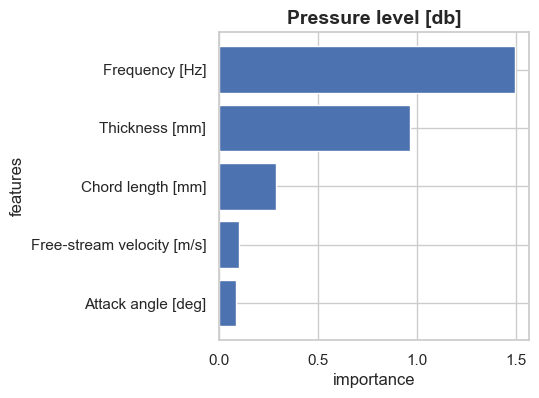

In [43]:
df.permutation_importance_plot(figsize=(4, 4), target=target)

In [44]:
permutation_importance_features = df.select_permutation_importance_features(len(df.columns)-1, target=target)
print('Признаки, выбранные перемешивающим методом:')
permutation_importance_features

Признаки, выбранные перемешивающим методом:


['Frequency [Hz]',
 'Thickness [mm]',
 'Chord length [mm]',
 'Free-stream velocity [m/s]',
 'Attack angle [deg]']

In [45]:
#df = df[permutation_importance_features]
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


### Признаки важные для случайного леса

In [46]:
df.random_forest_importance_features(target=target)

Thickness [mm]                0.429006
Frequency [Hz]                0.389953
Chord length [mm]             0.094403
Attack angle [deg]            0.044190
Free-stream velocity [m/s]    0.042448
dtype: float64

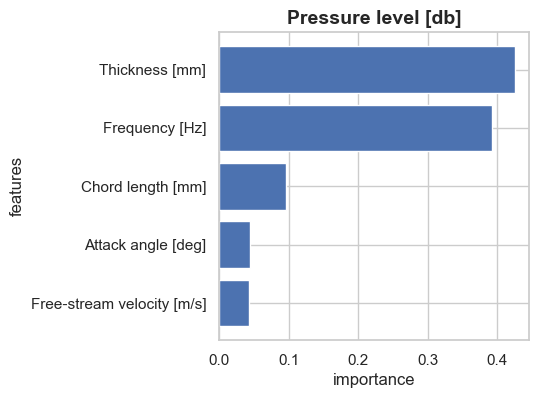

In [47]:
df.random_forest_importance_features_plot(figsize=(4, 4), target=target)

In [48]:
random_forest_importance_features = df.select_random_forest_importance_features(len(df.columns)-1, target=target)
print('Признаки важные для случайного леса:')
random_forest_importance_features

Признаки важные для случайного леса:


['Thickness [mm]',
 'Frequency [Hz]',
 'Chord length [mm]',
 'Attack angle [deg]',
 'Free-stream velocity [m/s]']

In [49]:
#df = df[random_forest_importance_features]
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


### k лучших признаков

In [50]:
k_best_features = df.select_k_best_features('f_regression', len(df.columns)-1, test_size=0.25, target=target)
print('k лучших признаков:')
k_best_features

score: 0.6043257565096387
k лучших признаков:


['Frequency [Hz]',
 'Attack angle [deg]',
 'Free-stream velocity [m/s]',
 'Chord length [mm]',
 'Thickness [mm]']

In [51]:
#df = df[k_best_features]
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


### % лучших признаков

In [52]:
percentile_features = df.select_percentile_features('f_regression', 80, test_size=0.25, target=target)
print('% лучших признаков:')
percentile_features

score: 0.6541126851530212
% лучших признаков:


,Frequency [Hz],Attack angle [deg],Chord length [mm],Thickness [mm]
0,800.0,0.0,304.8,2.66337
1,1000.0,0.0,304.8,2.66337
2,1250.0,0.0,304.8,2.66337
3,1600.0,0.0,304.8,2.66337
4,2000.0,0.0,304.8,2.66337
...,...,...,...,...
1498,2500.0,15.6,101.6,52.84870
1499,3150.0,15.6,101.6,52.84870
1500,4000.0,15.6,101.6,52.84870
1501,5000.0,15.6,101.6,52.84870


In [53]:
#df = df[percentile_features]
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


### k лучших признаков, выбранных путем рекурсивного удаления худших

In [54]:
elimination_features = df.select_elimination_features(len(df.columns)-1, 1, test_size=0.25, target=target)
print('k лучших признаков, выбранных путем рекурсивного удаления худших:')
elimination_features

score: 0.930843919261102
k лучших признаков, выбранных путем рекурсивного удаления худших:


,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Chord length [mm],Thickness [mm]
0,800.0,0.0,71.3,304.8,2.66337
1,1000.0,0.0,71.3,304.8,2.66337
2,1250.0,0.0,71.3,304.8,2.66337
3,1600.0,0.0,71.3,304.8,2.66337
4,2000.0,0.0,71.3,304.8,2.66337
...,...,...,...,...,...
1498,2500.0,15.6,39.6,101.6,52.84870
1499,3150.0,15.6,39.6,101.6,52.84870
1500,4000.0,15.6,39.6,101.6,52.84870
1501,5000.0,15.6,39.6,101.6,52.84870


In [55]:
#df = df[elimination_features]
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


### Признаки, выбранные из модели случайного леса

In [56]:
from_model_features = df.select_from_model_features(len(df.columns)-1, target=target)
print('Признаки, выбранные из модели случайного леса:')
from_model_features

Признаки, выбранные из модели случайного леса:


,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Chord length [mm],Thickness [mm]
0,800.0,0.0,71.3,304.8,2.66337
1,1000.0,0.0,71.3,304.8,2.66337
2,1250.0,0.0,71.3,304.8,2.66337
3,1600.0,0.0,71.3,304.8,2.66337
4,2000.0,0.0,71.3,304.8,2.66337
...,...,...,...,...,...
1498,2500.0,15.6,39.6,101.6,52.84870
1499,3150.0,15.6,39.6,101.6,52.84870
1500,4000.0,15.6,39.6,101.6,52.84870
1501,5000.0,15.6,39.6,101.6,52.84870


In [57]:
#df = df[from_model_features]
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


### Признаки, выбранные последовательно

In [58]:
%%time
sequential_features = df.select_sequential_features(len(df.columns)-1, 'forward', test_size=0.25, target=target)
print('Признаки, выбранные последовательно:')
sequential_features

Признаки, выбранные последовательно:
CPU times: total: 0 ns
Wall time: 3.01 ms


In [59]:
#df = df[sequential_features]
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


In [60]:
%%time
sequential_features = df.select_sequential_features(len(df.columns)-1, 'backward', test_size=0.25, target=target)
print('Признаки, выбранные последовательно:')
sequential_features

Признаки, выбранные последовательно:
CPU times: total: 31.2 ms
Wall time: 2.04 ms


In [61]:
#df = df[sequential_features]
df

,Frequency [Hz],Attack angle [deg],Free-stream velocity [m/s],Pressure level [db],Chord length [mm],Thickness [mm]
0,800,0.0,71.3,126.201,304.8,2.66337
1,1000,0.0,71.3,125.201,304.8,2.66337
2,1250,0.0,71.3,125.951,304.8,2.66337
3,1600,0.0,71.3,127.591,304.8,2.66337
4,2000,0.0,71.3,127.461,304.8,2.66337
...,...,...,...,...,...,...
1498,2500,15.6,39.6,110.264,101.6,52.84870
1499,3150,15.6,39.6,109.254,101.6,52.84870
1500,4000,15.6,39.6,106.604,101.6,52.84870
1501,5000,15.6,39.6,106.224,101.6,52.84870


## Понижение размерности

In [62]:
df.pca(1, test_size=0.25, target=target)

Объем вариации информации: [0.99907678]
Сингулярные значения: [122180.10419704]
Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [63]:
df.lda(4, test_size=0.25, target=target)

Unknown label type: (array([126.201, 125.201, 125.951, ..., 106.604, 106.224, 104.204]),)


In [64]:
df.nca(5, test_size=0.25, target=target)

Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


## Анализ необходимости нормализации и скалирования

In [65]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Frequency [Hz],1503.0,2886.380572,3152.573137,200.000000,800.00000,1600.00000,4000.0000,20000.0000
Attack angle [deg],1503.0,6.782302,5.918128,0.000000,2.00000,5.40000,9.9000,22.2000
Free-stream velocity [m/s],1503.0,50.860745,15.572784,31.700000,39.60000,39.60000,71.3000,71.3000
Pressure level [db],1503.0,124.835943,6.898657,103.380000,120.19100,125.72100,129.9955,140.9870
Chord length [mm],1503.0,136.548237,93.540728,25.400000,50.80000,101.60000,228.6000,304.8000
Thickness [mm],1503.0,11.139880,13.150234,0.400682,2.53511,4.95741,15.5759,58.4113


In [ ]:
df

In [ ]:
pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Экспорт обработанных данных

In [66]:
df.to_csv('datas/processed/airfoil_noise.csv', sep=',', index=False)

# Разделение данных для обучения и тестирования

In [68]:
test_size = 0.25
shuffle = True
random_state = 0

df_train, df_test = df.train_test_split(test_size=test_size, shuffle=shuffle, random_state=random_state)

In [69]:
df_train.shape, df_test.shape

((1127, 6), (376, 6))

# ML

## Поиск лучшей модели

In [72]:
model = Model(None)

NameError: name 'Model' is not defined

In [ ]:
models = model.fit_all(df_train_x, df_train_y, exceptions=False)

In [ ]:
warnings.filterwarnings('ignore')

errors, scores = dict(), dict()

for model in tqdm(models):
    try:
        predictions = model.predict(df_test_x)
        errors[str(model)] = model.errors(df_test_y, predictions, exceptions=False)
        scores[str(model)] = model.scores(df_test_y, predictions, exceptions=False)
    except:
        pass    
    
warnings.filterwarnings('default')

In [ ]:
errors = DataFrame(errors)
errors

In [ ]:
scores = DataFrame(scores)
scores

In [ ]:
stats = pd.concat([errors, scores], axis=0)
stats

Удаление неподходящих моделей с отрицательными метриками

In [ ]:
stats = stats.transpose()
stats = stats[(stats >= 0).all(axis=1)]
stats = stats.transpose()
stats

In [ ]:
cmap = sns.color_palette('coolwarm', as_cmap=True)
stats.style.background_gradient(cmap=cmap)

In [ ]:
for i, model in enumerate(models):
    if str(model) in stats.columns:
        print(f'{i}) {model}')

In [ ]:
model = Model(models[23]())
model()

In [ ]:
model.prediction(df_test_y, model.predict(df_test_x))

In [ ]:
model.plot_tree(feature_columns=df_train_x.columns)

# Улучшение модели

In [ ]:
for key, value in vars(model()).items():
    if not key.lower().startswith('_') and not key.lower().endswith('_'):
        if isiter(value) and type(value) is not str:
            print(f'{key}:')
            for v in value:
                print('\t' + f'{v}')
        else:
            print(f'{key}: {value}')

In [ ]:
param_grid = {'n_estimators': range(30, 100, 5),
              'max_depth': range(5, 50, 5),
              'n_jobs': [-1],
              'verbose': [True]}

In [ ]:
gscv = GridSearchCV(model(), 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    verbose=True)

In [ ]:
%%time
gscv.fit(df_train_x, df_train_y)

In [ ]:
gscv.best_params_

In [ ]:
gscv.best_score_

In [ ]:
model = Model(gscv.best_estimator_)
model

In [ ]:
model().score(df_test_x, df_test_y)

## Смещение, весовые коэффициенты и уравнение

In [ ]:
model.intercept_

In [ ]:
model.coef_

In [ ]:
model.expression

# Экспорт модели

In [ ]:
model.save('model_sklearn.pkl')
model()

# Стэккинг

In [ ]:
stacking = Stacking()

# Бэггинг

In [ ]:
model = model
model

In [ ]:
bagging = Bagging(model())

# Бустинг

In [ ]:
boosting = Boosting()

# DL

In [ ]:
normalizer = Normalization(axis=-1)
normalizer

In [ ]:
normalizer.adapt(np.array(df.drop([target], axis=1)))

In [ ]:
model = Sequential()

model.add(Input(shape=(len(df.columns)-1,)))
model.add(normalizer)
model.add(layers.Flatten())
#model.add(layers.Dense(units=64, activation=activations.relu, input_shape=[len(train_df.keys())]))
#model.add(layers.Dense(units=64, activation=activations.relu))
model.add(layers.Dense(units=1))

In [ ]:
model.summary()

# Компиляция модели

tf.optimizers.

1) SGD  # Классический оптимизатор, который обновляет веса в направлении антиградиента функции потерь
2) Adam  # Оптимизатор, сочетающий в себе преимущества адаптивного градиентного спуска (Adagrad) и Root Mean Square Propagation (RMSprop).
3) RMSprop  # Оптимизатор адаптирует скорость обучения для каждого параметра на основе истории градиентов для этого параметра.
4) Adagrad  # Оптимизатор уменьшает скорость обучения для параметров, которые редко или никогда не обновлялись, и увеличивает скорость обучения для параметров, которые часто обновлялись
5) Adadelta  # Оптимизатор является расширением Adagrad и использует только последние градиенты для обновления параметров.
6) Adamax  # Оптимизатор является вариантом Adam, который использует бесконечную норму вместо L2 нормы для обновления параметров.
6) Nadam  # Оптимизатор является комбинацией методов Nesterov Accelerated Gradient (NAG) и Adam

In [ ]:
learning_rate = 0.1
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
loss = 'mae'
metrics =  ['mae', 'mse']

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Обучение модели

In [ ]:
epochs = 100
batch_size = 32
verbose = False  # динамическое прогресс

monitor = 'loss' # что мониторить
min_delta = 0.01 # сравнивать с каким значением
patience = 5 # в течении скольких эпох

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose),
             keras.callbacks.ModelCheckpoint(monitor=monitor, filepath='checkpoints/model_{epoch:d}.keras', save_best_only=True, verbose=verbose),
             keras.callbacks.CSVLogger('log.csv', separator=",", append=False),
             keras.callbacks.TerminateOnNaN()]

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=epochs,
    validation_data=(test_features, test_labels),
    #validation_split = 0.2,  # данные ранее не были разделены на тренировочные и тестовые
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=verbose)

# Анализ обучения

In [ ]:
max(history.epoch)

In [ ]:
training_plot(history, figsize=(22, 6), savefig=True)

In [ ]:
hist = pd.DataFrame(history.history)
hist.index.rename('epoch', inplace=True)
hist.tail()

Оценка производительности модели

In [ ]:
test_results = dict()
test_results['model'] = model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
test_results

In [ ]:
test_predictions = model.predict(test_features.to_numpy()).flatten()

In [ ]:
predictions_plot(test_labels, test_predictions, figsize=(12, 5), savefig=True)

# Экспорт модели

In [ ]:
model_name = 'model_tf'
model_name += '.keras'

In [ ]:
if model_name not in os.listdir(): 
    model.save(model_name)
    print('model has saved')
else:
    print('model has not saved!')

In [ ]:
os.path.exists(model_name)

In [ ]:
model.save(model_name)

# Тестирование

# Импорт модели

In [ ]:
os.listdir()

In [ ]:
model_sklearn = Model().load('model_sklearn.pkl')
model_tf = keras.models.load_model('model_tf.keras')

## Автоматическое тестирование

In [ ]:
pred_df = pd.concat([df.iloc[:, -1:],
           pd.DataFrame(model_sklearn.predict(df.iloc[:, :-1]), columns=['Predicted Pressure level [db]'])], 
           axis=1)
pred_df

In [ ]:
pred_df = pd.concat([df.iloc[:, -1:],
           pd.DataFrame(model_tf.predict(df.iloc[:, :-1]), columns=['Predicted Pressure level [db]'])], 
           axis=1)
pred_df

## Ручное тестирование

In [ ]:
df

In [ ]:
airfoil_props = {"Frequency [Hz]": [1000], 
                 "Attack angle [deg]": [4], 
                 "Chord length [m]" : [0.2], 
                 "Free-stream velocity [m/s]": [40], 
                 "Thickness [m]": [0.09]}
airfoil_props = pd.DataFrame(airfoil_props)
airfoil_props

In [ ]:
%%time
for predict in model_tf.predict(airfoil_props.to_numpy()):
    print(f'Pressure level [db]: {predict[0]} ')

In [ ]:
pd.concat([airfoil_props, pd.DataFrame(model_sklearn.predict(airfoil_props.to_numpy()), columns=['Pressure level [db]'])], axis=1)

In [ ]:
pd.concat([airfoil_props, pd.DataFrame(model_tf.predict(airfoil_props.to_numpy()), columns=['Pressure level [db]'])], axis=1)

# Экспорт лучшей модели

In [ ]:
model_sklearn.save('model_airfoil_noise.pkl')